(solid-mechanics:intro:small-displacements-beam-fem:decoupled)=
# Decoupled beam

## Single straight beam

### Axial dynamics

$$\begin{aligned}
  m \ddot{s}_z - \left( EA s'_z \right)' = f_z
\end{aligned}$$


Piecewise **first-degree polynomial** approximation of the displacement. The base functions on the reference element $\xi \in [-1,1]$ are

$$
  \phi_1(\xi) = \frac{1}{2} \left( 1 - \xi \right) \quad , \quad
  \phi_2(\xi) = \frac{1}{2} \left( 1 + \xi \right) 
$$

and their first order derivatives read

$$
  \phi'_1(\xi) = - \frac{1}{2} \quad , \quad
  \phi'_2(\xi) =   \frac{1}{2}
$$


**Weak formulation.**

$$\int_{\ell} w m \ddot{s} + \int_{\ell} w' EA s' = \int_{\ell} w f + \left.\left[ w EA s' \right]\right|_{\partial \ell}$$


**Discrete problem.** Exploiting additivity of the integrals over partition of domains,

$$\int_{\ell} = \sum_{k} \int_{\ell_k}$$

introducing the approximation $s(x,t) = \sum_{j} \phi_j(x) s_j(t) = \boldsymbol\phi(x)^T \mathbf{s}(t)$, and testing over all the base functions $\phi_i(x)$, the discrete problem reads

$$\int_{\ell} \phi_i(x) m \phi_j(x) \, dx \, \ddot{s}_j + \int_{\ell} \phi'_i(x) EA \phi'_j(x) \, dx \, s_j = \int_{\ell} \phi_i(x) f(x) \, dx + \left.\left[ \phi_i EA s' \right]\right|_{\partial \ell} \ .$$

In the $i^{th}$ equation, non-zero contributions only come from elements $k$ where both $\phi_i$, $\phi_j$ are simultaneously non-zero.



#### Example: clamped-free beam


In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

#> Parameters
#> Physical parameters
l, m, EA = 1., 1., 1.
f = .0

#> Discretization parameters, for building mesh
nelems = 3
nnodes = nelems + 1

#> Boundary conditions
u0, F1 = .0, 1.   # Dirichlet (displ) in P0, Neumann (force) in P1
i_dir = [ 0 ]
u_dir = [ u0 ]
i_neu = [ nnodes-1 ]
f_neu = [ F1 ]


In [2]:
#> Mesh
#> Node coordinates
rr = np.linspace(0, 1, nnodes) * l
#> Node-element connectivity matrix
ee = np.array([ [ iel, iel+1 ] for iel in np.arange(nelems) ])

print(rr)
print(ee)

[0.         0.33333333 0.66666667 1.        ]
[[0 1]
 [1 2]
 [2 3]]


$$\begin{aligned}
  M_{11}^{loc} = M_{22}^{loc} & = \int_{\xi=-1}^{1} \left( \dfrac{1}{2} \left( 1- \xi \right)\right)^2 d \xi = \frac{1}{4} \left( 2 + \dfrac{2}{3} \right) = \dfrac{2}{3} \\
  M_{12}^{loc} & = \int_{\xi=-1}^{1} \dfrac{1}{4} \left( 1 - \xi \right) \left( 1 + \xi \right) d \xi = \dfrac{1}{3} 
\end{aligned}$$

In [3]:
#> Local mass and stiffness matrices
#> Length of the elements
el_len = np.array([ np.abs(rr[ee[iel,0]] - rr[ee[iel,1]]) for iel in np.arange(nelems) ])
el_jac = el_len * .5
# print(el_len)

#> Local mass matrix, stripped by row
me_loc = np.array([ 2., 1., 1., 2. ]) / 3.

#> Local stiffness matrix, stripped by row
ke_loc = np.array([ .5, -.5, -.5, .5 ])


In [4]:
#> Assembling global matrices
mi = np.concatenate(np.array([ [ e[0], e[0], e[1], e[1] ] for e in ee]))
mj = np.concatenate(np.array([ [ e[0], e[1], e[0], e[1] ] for e in ee]))

me = np.concatenate([ me_loc * m  * el_jac[iel] for iel in np.arange(nelems) ])
ke = np.concatenate([ ke_loc * EA / el_jac[iel] for iel in np.arange(nelems) ])

M = sp.sparse.coo_array((me, (mi, mj)),)
K = sp.sparse.coo_array((ke, (mi, mj)),)

# print(M.todense())
# print(K.todense())


##### Static problem

[0. 0. 1.]
[[ 6. -3.  0.]
 [-3.  6. -3.]
 [ 0. -3.  3.]]
[0.33333333 0.66666667 1.        ]


Text(0, 0.5, 'u')

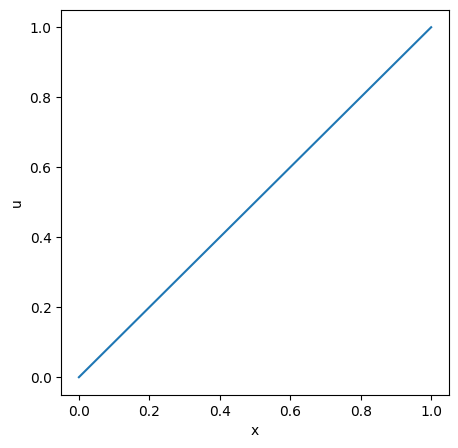

In [5]:
#> Prescribe boundary conditions
# 1) Slicing or 2) augmented system
#> 1) Slicing
# [ Kuu Kud ][ uu ] = [ fu ] + [ Fu ]
# [ Kdu Kdd ][ ud ]   [ fd ]   [ Fd ]
iD = i_dir.copy()
iU = list(set(np.arange(nnodes))-set(iD))

Kuu = (K.tocsc()[:,iU]).tocsr()[iU,:]
Kud = (K.tocsc()[:,iD]).tocsr()[iU,:]
Kdu = (K.tocsc()[:,iU]).tocsr()[iD,:]
Kdd = (K.tocsc()[:,iD]).tocsr()[iD,:]

F_vol = np.zeros(nnodes)
f = F_vol.copy()
f[i_neu] += F1
fu = f[iU]
fd = f[iD]

ud = u_dir.copy()

print(fu)
print(Kuu.todense())

#> Solve the linear problem, and retrieve the solution
uu = sp.sparse.linalg.spsolve(Kuu, fu - Kud @ ud )
fd = Kdu @ uu + Kdd @ ud

print(uu)

u = np.zeros(nnodes);  u[iU] = uu;  u[iD] = ud
f = np.zeros(nnodes);  f[iU] = fu;  f[iD] = fd

fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.plot(rr, u)
ax.set_xlabel('x')
ax.set_ylabel('u')



### Torsional dynamics

$$\begin{aligned}
  I_z \ddot{\theta}_z - \left( GJ_z \theta'_z \right)' = m_z
\end{aligned}$$


Same as axial dynamics...

### Shear-Bending dynamics


$$\begin{cases}
  & m \ddot{s}_x - \left( \chi_x^{-1}GA ( s'_x - \theta_y ) \right)' = f_x \\
  & I_y \ddot{\theta}_y - \left( EJ \theta_y' \right)' - \chi_x^{-1}GA \left( s_x' - \theta_y \right) = m_x
\end{cases}$$


$$\begin{cases}
  & m \ddot{s}_y - \dots = f_y \\
  & I_x \ddot{\theta}_x - \dots = m_x
\end{cases}$$

Finite-dimensional approximation

$$\begin{aligned}
  s(x,t) & = \boldsymbol\phi_s^T(x) \mathbf{s}(t) \\
  \theta(x,t) & = \boldsymbol\phi_\theta^T(x) \boldsymbol{\theta}(t) \\
\end{aligned}$$


$$\begin{cases}
  \int_{\ell} \boldsymbol\phi_s m \boldsymbol\phi_s^T \, dx \, \ddot{\mathbf{s}} + \int_{\ell} \boldsymbol\phi'_s \chi^{-1} GA \left( \boldsymbol\phi_s^{' \ T} \mathbf{s} - \boldsymbol\phi^T_\theta \boldsymbol\theta \right) \, dx = \int_{\ell} \boldsymbol\phi^T_s \, f + \left.\left[ \boldsymbol\phi_s  \underbrace{ \chi^{-1}GA( \boldsymbol\phi^{' \ T}_s \mathbf{s} - \boldsymbol\phi^T_\theta \boldsymbol\theta) }_{T} \right]\right|_{\partial \ell} \\
    \int_{\ell} \boldsymbol\phi_\theta I \boldsymbol\phi_\theta^T \, dx \, \ddot{\boldsymbol{\theta}} + \int_{\ell} \boldsymbol\phi'_\theta EJ \boldsymbol\phi_\theta^{' \ T} \boldsymbol{\theta} - \int_{\ell} \boldsymbol\phi_\theta \chi^{-1} GA \left( \boldsymbol\phi^{' \ T}_s \mathbf{s} - \boldsymbol\phi^T_\theta \boldsymbol\theta \right)\, dx = m + \left.\left[ \boldsymbol\phi_\theta  \underbrace{ EJ \boldsymbol\phi^{' \ T}_\theta \boldsymbol{\theta} }_{M} \right]\right|_{\partial \ell}
\end{cases}$$

$$\begin{bmatrix} \int_{\ell} \boldsymbol\phi_s m \boldsymbol\phi_s^T & 0 \\ 0 & \int_{\ell} \boldsymbol\phi_\theta I \boldsymbol\phi_\theta^T \end{bmatrix}\begin{bmatrix} \ddot{\mathbf{s}} \\ \ddot{\boldsymbol{\theta}} \end{bmatrix} + \begin{bmatrix} \int_{\ell} \boldsymbol\phi'_s \chi^{-1} GA \boldsymbol\phi_s^{' \ T} & -\int_{\ell} \boldsymbol\phi'_s \chi^{-1} GA \boldsymbol\phi_\theta^{T} \\  -\int_{\ell} \boldsymbol\phi_\theta \chi^{-1} GA \boldsymbol\phi_s^{' \ T} & \int_{\ell} \boldsymbol\phi'_\theta EJ \boldsymbol\phi_\theta^{' \ T} + \int_{\ell} \boldsymbol\phi_\theta \chi GA \boldsymbol\phi_\theta^{T} \end{bmatrix}\begin{bmatrix} \mathbf{s} \\ \boldsymbol{\theta} \end{bmatrix} = \begin{bmatrix} \dots \\ \dots \end{bmatrix}$$

Different approximations for displacement and rotation

$$\begin{aligned}
  \phi^s_1(\xi) & = \dfrac{1}{2} \xi ( \xi - 1 ) && , \quad \phi^{s \ '}_1(\xi) = \xi - \dfrac{1}{2} \\
  \phi^s_2(\xi) & = 1 - \xi^2                    && , \quad \phi^{s \ '}_2(\xi) = - 2 \xi \\
  \phi^s_3(\xi) & = \dfrac{1}{2} \xi ( \xi + 1 ) && , \quad \phi^{s \ '}_3(\xi) = \xi + \dfrac{1}{2} \\
\end{aligned}$$

$$\begin{aligned}
  \phi^\theta_1(\xi) & = \dfrac{1}{2} ( 1 - \xi ) && , \quad \phi^{\theta \ '}_1(\xi) = - \dfrac{1}{2} \\
  \phi^\theta_2(\xi) & = \dfrac{1}{2} ( 1 + \xi ) && , \quad \phi^{\theta \ '}_2(\xi) =   \dfrac{1}{2} \\
\end{aligned}$$

$$\mathbf{M}_{ss} = \begin{bmatrix} 
\frac{4}{15} & \frac{2 }{15} & -\frac{1}{15} \\
\cdot        & \frac{16}{15} &  \frac{2}{15} \\
\cdot        & \cdot         &  \frac{4}{15}
\end{bmatrix}$$

$$\mathbf{K}_{ss} = \begin{bmatrix} 
\frac{7}{6} & -\frac{4}{3} &  \frac{1}{6} \\
\cdot       &  \frac{8}{3} & -\frac{4}{3} \\
\cdot       & \cdot        &  \frac{7}{6}
\end{bmatrix}$$

$$\mathbf{A}_{s\theta} = \begin{bmatrix} 
 -\frac{5}{6} & -\frac{1}{6} \\
  \frac{1}{3} & -\frac{1}{3} \\
  \frac{1}{6} &  \frac{5}{6}       
\end{bmatrix}$$

as

$$\begin{aligned}
  A_{11} & = \int_{-1}^{1} \phi^{s \ '}_1(\xi) \phi^{\theta}_1(\xi) \, d \xi
  = \int_{-1}^{1} \left( \xi - \frac{1}{2} \right) \frac{1}{2} \left( 1 - \xi \right) d \xi
  = \int_{-1}^{1} \left( -\frac{1}{4} - \frac{1}{2} \xi^2 \right) d \xi = - \dfrac{1}{2} - \dfrac{1}{3} = - \dfrac{5}{6} \\
    A_{12} & = \int_{-1}^{1} \phi^{s \ '}_1(\xi) \phi^{\theta}_2(\xi) \, d \xi
  = \int_{-1}^{1} \left( \xi - \frac{1}{2} \right) \frac{1}{2} \left( 1 + \xi \right) d \xi
  = \int_{-1}^{1} \left( -\frac{1}{4} + \frac{1}{2} \xi^2 \right) d \xi = - \dfrac{1}{2} + \dfrac{1}{3} = - \dfrac{1}{6} \\
    A_{21} & = \int_{-1}^{1} \phi^{s \ '}_2(\xi) \phi^{\theta}_1(\xi) \, d \xi
  = \int_{-1}^{1} \quad - 2 \xi \quad \ \frac{1}{2} \left( 1 - \xi \right) d \xi
  = \int_{-1}^{1} \qquad \quad \ \ \ \ \ \ \xi^2 \quad d \xi = \ \ \ \dfrac{1}{3} \\
    A_{22} & = \int_{-1}^{1} \phi^{s \ '}_2(\xi) \phi^{\theta}_2(\xi) \, d \xi
  = \int_{-1}^{1} \quad - 2 \xi \quad \ \frac{1}{2} \left( 1 + \xi \right) d \xi
  = \int_{-1}^{1} \qquad \quad \ \ - \xi^2 \quad d \xi = - \dfrac{1}{3} \\
    A_{31} & = \int_{-1}^{1} \phi^{s \ '}_3(\xi) \phi^{\theta}_1(\xi) \, d \xi
  = \int_{-1}^{1} \left( \xi + \frac{1}{2} \right) \frac{1}{2} \left( 1 - \xi \right) d \xi
  = \int_{-1}^{1} \left( \ \ \ \frac{1}{4} - \frac{1}{2} \xi^2 \right) d \xi = \ \ \ \dfrac{1}{2} - \dfrac{1}{3} = \dfrac{1}{6} \\
    A_{32} & = \int_{-1}^{1} \phi^{s \ '}_3(\xi) \phi^{\theta}_2(\xi) \, d \xi
  = \int_{-1}^{1} \left( \xi + \frac{1}{2} \right) \frac{1}{2} \left( 1 + \xi \right) d \xi
  = \int_{-1}^{1} \left( \ \ \ \frac{1}{4} + \frac{1}{2} \xi^2 \right) d \xi = \ \ \ \dfrac{1}{2} + \dfrac{1}{3} = \dfrac{5}{6} \\
\end{aligned}$$

In [6]:
%reset -f


In [7]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

#> Parameters
#> Physical parameters
l = 1.                  # length
m, I = 1., 1.           # mass and inertia density
EJ = 1.                 # bending stiffness
xGA = 100. * EJ         # shear stiffness (relative to bending stiffness)
qf, qm = .0, .0         # distributed loads, force and moments

#> Discretization parameters, for building mesh
nelems = 1
nnodes_p1 = nelems + 1
nnodes_p2 = nelems
nnodes = nnodes_p1 + nnodes_p2

#> Boundary conditions
u0, theta0 = .0, .0    # clamp in P0
F1, M1 = 1., .0        # only force in P1


In [8]:
#> Mesh
# Not only P1 elements, but P1(rotation)-P2(displacement) elements
#> Node coordinates (nnodes,nd), with space dimension nd=1
rr = np.linspace(0, 1, nnodes_p1) * l                 # P1 nodes (equi-spaced)
rr = np.concatenate([rr, .5*(rr[1:] + rr[:-1])])      # concatentate P1 with P2 nodes
#> Node-element connectivity matrix (nelems,3)
# First two ids: P1-nodes, third id: P2-node
ee = np.array([ [ iel, iel+1, nnodes_p1+iel ] for iel in np.arange(nelems) ])

#> Global indices
# Some nodes have 2 variables (P1 have both displacement and rotation). In order to 
# assemble global matrices, global indices of the variables are required
i_displ = ee.copy()
i_theta = ee[:,:2].copy() + nnodes
i_var = np.block([i_displ, i_theta])

n_vars = nnodes + nnodes_p1

print(rr)
print(ee)
# print(i_displ)
# print(i_theta)
print(i_var)

[0.  1.  0.5]
[[0 1 2]]
[[0 1 2 3 4]]


In [9]:
#> Local mass and stiffness matrices
#> Length of the elements
el_len = np.array([ np.abs(rr[ee[iel,0]] - rr[ee[iel,1]]) for iel in np.arange(nelems) ])
el_jac = el_len * .5
# print(el_len)

#> Local mass matrix, stripped by row
me_tt_loc = np.array([ 2., 1., 1., 2. ]) / 3.
me_ss_loc = np.array([ 4., -1., 2., -1., 4., 2., 2., 2., 16.]) / 15.

#> Local stiffness matrix, stripped by row
ke_tt_loc = np.array([ .5, -.5, -.5, .5 ])
ke_ss_loc = np.array([ 7., 1., -8., 1., 7., -8., -8., -8., 16.]) / 6.

#> Ast
# [ -5, -1 ]
# [  1,  5 ]
# [  2, -2 ] / 6
ae_st_loc = np.array([-5., -1., 1., 5., 2., -2.]) / 6.
ae_ts_loc = np.array([-5., 1., 2., -1., 5., -2.]) / 6.






In [10]:
#> Assembling global matrices
#> Mass
mi_ss = np.concatenate(np.array([ np.repeat(i_var[iel,:3], [3,3,3]) for iel in np.arange(nelems)]))
mj_ss = np.concatenate(np.array([ np.tile(i_var[iel,:3],3) for iel in np.arange(nelems)]))
me_ss = np.concatenate([ me_ss_loc * m * el_jac[iel] for iel in np.arange(nelems)])

mi_tt = np.concatenate(np.array([ np.repeat(i_var[iel,3:], [2,2]) for iel in np.arange(nelems)]))
mj_tt = np.concatenate(np.array([ np.tile(i_var[iel,3:],2) for iel in np.arange(nelems)]))
me_tt = np.concatenate([me_tt_loc * I * el_jac[iel] for iel in np.arange(nelems)])

mi = np.concatenate([mi_ss, mi_tt])
mj = np.concatenate([mj_ss, mj_tt])
me = np.concatenate([me_ss, me_tt])

M = sp.sparse.coo_array((me, (mi,mj)),)


#> Stiffness
ke_ss    = np.concatenate([ ke_ss_loc * xGA / el_jac[iel] for iel in np.arange(nelems)])
ke_tt_EJ = np.concatenate([ ke_tt_loc * EJ  / el_jac[iel] for iel in np.arange(nelems)])
ke_tt_GA = np.concatenate([ me_tt_loc * xGA * el_jac[iel] for iel in np.arange(nelems)])
ke_tt    = ke_tt_EJ + ke_tt_GA

ai_st = np.concatenate(np.array([ np.repeat(i_var[iel,:3], [2,2,2]) for iel in np.arange(nelems)]))
aj_st = np.concatenate(np.array([ np.tile(i_var[iel,3:],3) for iel in np.arange(nelems)]))

ai_ts = np.concatenate(np.array([ np.repeat(i_var[iel,3:], [3,3]) for iel in np.arange(nelems)]))
aj_ts = np.concatenate(np.array([ np.tile(i_var[iel,:3],2) for iel in np.arange(nelems)]))

ke_st    = np.concatenate([ - ae_st_loc * xGA for iel in np.arange(nelems)])
ke_ts    = np.concatenate([ - ae_ts_loc * xGA for iel in np.arange(nelems)])

ki = np.concatenate([ mi_ss, ai_st, ai_ts, mi_tt ])
kj = np.concatenate([ mj_ss, aj_st, aj_ts, mj_tt ])
ke = np.concatenate([ ke_ss, ke_st, ke_ts, ke_tt ])

K = sp.sparse.coo_array((ke, (ki,kj)),)

print("\nMass matrix:")
print(M.todense())
print(np.sum(M))

print("\nStiffness matrix:")
print(K.todense())
print("Null space:")
print("!!! ERROR, and need for debug !!!")
print("Expected a 2-dimensional null space (rigid translation and rotation)")
print("Got 1-dimensional null space")
print(sp.linalg.null_space(K.todense()))


# me = np.concatenate([ me_loc * el_jac[iel] for iel in np.arange(nelems) ])
# ke = np.concatenate([ ke_loc / el_jac[iel] for iel in np.arange(nelems) ])

# M = sp.sparse.coo_array((me, (mi, mj)),)
# K = sp.sparse.coo_array((ke, (mi, mj)),)

# print(M.todense())
# print(K.todense())



Mass matrix:
[[ 0.13333333 -0.03333333  0.06666667  0.          0.        ]
 [-0.03333333  0.13333333  0.06666667  0.          0.        ]
 [ 0.06666667  0.06666667  0.53333333  0.          0.        ]
 [ 0.          0.          0.          0.33333333  0.16666667]
 [ 0.          0.          0.          0.16666667  0.33333333]]
2.0

Stiffness matrix:
[[ 233.33333333   33.33333333 -266.66666667   83.33333333   16.66666667]
 [  33.33333333  233.33333333 -266.66666667  -16.66666667  -83.33333333]
 [-266.66666667 -266.66666667  533.33333333  -33.33333333   33.33333333]
 [  83.33333333  -16.66666667  -33.33333333   34.33333333   15.66666667]
 [  16.66666667  -83.33333333   33.33333333   15.66666667   34.33333333]]
Null space:
!!! ERROR, and need for debug !!!
Expected a 2-dimensional null space (rigid translation and rotation)
Got 1-dimensional null space
[[ 3.16227766e-01]
 [-3.16227766e-01]
 [ 2.22044605e-16]
 [-6.32455532e-01]
 [-6.32455532e-01]]


#### Example: clamped beam


[1, 2, 4]
[0 3]
[-0.02644647 -0.00980638 -0.0546697 ]
3
[0.  1.  0.5]


Text(0.5, 0, 'x')

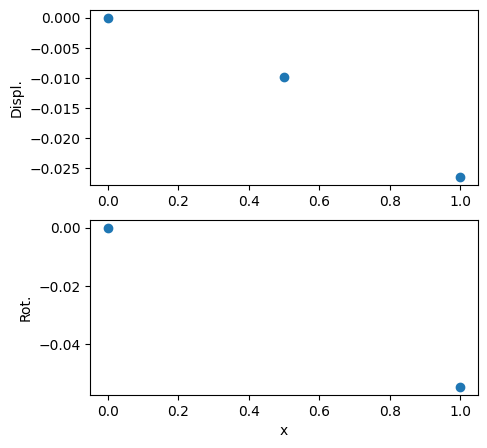

In [11]:
#> Essential boundary conditions
iD = np.array([ 0, nnodes ])   # var index of displ and rot of the first node
uD = np.array([ .0, .0 ])      # value of the displ and rot of the first node

iN = np.array([ nnodes_p1 - 1 ])    # var index of the displ of the last node
fN = np.array([ 1. ])

iU = list(set(np.arange(n_vars)) - set(iD))

#> Slicing
Kuu = (K.tocsc()[:,iU]).tocsr()[iU,:]
Kud = (K.tocsc()[:,iD]).tocsr()[iU,:]
Kdu = (K.tocsc()[:,iU]).tocsr()[iD,:]
Kdd = (K.tocsc()[:,iD]).tocsr()[iD,:]

F_vol = np.zeros(n_vars)
f = F_vol.copy()
f[iN] += fN
fu = f[iU]
fd = f[iD]

#> Solve the linear problem, and retrieve the solution
uu = sp.sparse.linalg.spsolve(Kuu, fu - Kud @ uD )
fd = Kdu @ uu + Kdd @ uD

print(iU)
print(iD)
print(uu)

nU = len(iU)
u = np.zeros(n_vars);  u[iU] = uu;  u[iD] = uD

u_displ = u[:nnodes]
u_rot   = u[nnodes:]

print(nnodes)
print(rr)

fig, ax = plt.subplots(2,1, figsize=(5,5))
ax[0].plot(rr            , u_displ, 'o')
ax[1].plot(rr[:nnodes_p1], u_rot  , 'o')
ax[0].set_ylabel('Displ.')
ax[1].set_ylabel('Rot.')
ax[1].set_xlabel('x')


